<img align="top" width="250" height="70" src="https://s3.amazonaws.com/samples.clarifai.com/logo/clarifai_logo.png" alt="banner">

&nbsp;

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/main/inference/face_model_prediction_to_annotation.ipynb)

# General Information

In this notebook we are going to take an image (publicly accessible URLs or local uploads) and run it through Clarifai's Face Detection model. Then we will take the bounding boxes returned by the model and plot them as a bounding box on the image

## How to Run
You can run each code cell independently by using `SHIFT + ENTER`. You can also run the whole notebook (all cells) using `RUN ALL`.

## Expected inputs

- An PAT key token **(required)**

# Table of contents

- [Importing the libraries](#basic-info)
- [Setting up the task](#basic-info)
- [Sending the image for prediction - publicly accessible URL](#predict-image)
- [Parse response](#parse-response)
- [Plot the prediction](#plot-image)

In [ ]:
!pip install -q clarifai-grpc && pip install --upgrade --no-deps -q protobuf 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 KB 8.5 MB/s eta 0:00:00


In [ ]:

## importing the libraries
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import service_pb2_grpc,service_pb2,resources_pb2
from clarifai_grpc.grpc.api.status import status_code_pb2
from google.protobuf.json_format import MessageToDict


from skimage import io
import cv2
import os
import numpy as np
from PIL import Image, ImageDraw
import urllib.request as urllib


In [ ]:
# Create a stub which will be used to interact with the API 
stub = service_pb2_grpc.V2Stub(ClarifaiChannel.get_grpc_channel())
 

In [ ]:
# Your PAT (Personal Access Token) can be found in the portal under Authentification
PAT = 'YOUR_PAT_HERE'
# Specify the correct user_id/app_id pairings
# Since you're making inferences outside your app's scope
USER_ID = 'clarifai'
# APP_ID = 'main'


metadata = (('authorization', 'Key ' + PAT),)
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)



<a id='basic-info'></a>
### The libraries have been imported and the stub (for connection to the API has been created).

I have an app whose base workflow is the face model and I am going to make predictions to it to see if it can identify where in the input the model can find face. We will then extract bounding box coordinates for those faces. 

To do this we will just need to replace your API key for an app whose base workflow is Face to get the same results.

I will be sending the following image for prediction.

![test_image](https://i2-prod.mirror.co.uk/incoming/article21353780.ece/ALTERNATES/s615b/3_Doctor-Who-Series-11ed.jpg)

### We are going to read in the image using *urllib.request* library and then use the Image module from Pillow library to get the size of the image. We will need the size dimensions of the image to put the bounding box back on the image 

In [ ]:
img_url = 'https://i2-prod.mirror.co.uk/incoming/article21353780.ece/ALTERNATES/s615b/3_Doctor-Who-Series-11ed.jpg'
url = urllib.urlopen(img_url)

img= Image.open(url)


<a id='predict-image'></a>
### Predicting with a publically accessible URL

1. Give it our API key from the app that has a base workflow of Face. 
2. Give it the correct model id of the Face detection model which is *d02b4508df58432fbb84e800597b8959* but you can always get the most recent version from our Model gallery [here](https://www.clarifai.com/models/face-detection)

**Uncomment code in the following cell to run prediction on a publically accessible URL**

In [ ]:
# Setting up an API connection with an API key
# The API key needs to be from the application where the model was created. 


face_response = stub.PostModelOutputs(
    service_pb2.PostModelOutputsRequest(
        user_app_id=userDataObject,
        model_id="face-detection", # FACE model id 
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(
                    image=resources_pb2.Image(
                        url="https://i2-prod.mirror.co.uk/incoming/article21353780.ece/ALTERNATES/s615b/3_Doctor-Who-Series-11ed.jpg"
                    )
                )
            )
        ]
    ),
    metadata=metadata
)
if face_response.status.code != status_code_pb2.SUCCESS:
    raise Exception("Post model outputs failed, status: " + face_response.status.description)
else:
    print('prediction made successfully')

prediction made successfully


<a id='parse-response'></a>
### The raw response from the API with face detection can be viewed by uncommenting the next cell. 

In [3]:
#face_response

### However, we are going to only get the *region_info* section of the response into a dictionary which we can use the google protobuf library to convert it into a dictionary which we can manipulate

In [ ]:
bbox_data = face_response.outputs[0].data.regions[0].region_info

bbox_dict = MessageToDict(bbox_data)['boundingBox']
bbox_dict

{'topRow': 0.06526124,
 'leftCol': 0.60849786,
 'bottomRow': 0.16295171,
 'rightCol': 0.72137964}

<a id='plot-image'></a>
#### The bounding box coordinates are a ratio with respect to the height and width of the image so we are going to store those and use them to get the values to put them back them on the image. 

In [ ]:
height, width, _ = np.shape(img)
np.shape(img)

(870, 615, 3)

In [ ]:
# width, height = img.size
print('width: {}\nheight: {}'.format(width, height))

width: 615
height: 870


**The row values that we returned will be multiplied by the height and the column values with the width**

In [ ]:

row_coords = {}
col_coords = {}

for k,v in bbox_dict.items():#     
    if 'row' in k.lower():
        row_coords[k] = int(np.round(v*height))
    else:
        col_coords[k] = int(np.round(v*width))
        



In [ ]:
print('The row coordinates are below')
for r,r_val in row_coords.items():
    print(r,r_val)
print('\n')

print('The column coordinates are below')
for c, c_val in col_coords.items():
    print(c,c_val)

The row coordinates are below
topRow 57
bottomRow 142


The column coordinates are below
leftCol 374
rightCol 444


In [ ]:
#top left corner of the bounding box
start_point = (col_coords['leftCol'],row_coords['topRow'])
# represents the bottom right corner of rectangle 
end_point = (col_coords['rightCol'],row_coords['bottomRow'])

In [ ]:
 
print('Start Points :',start_point)
print('  End Points :', end_point)

Start Points : (374, 57)
  End Points : (444, 142)


In [ ]:
img_url = 'https://i2-prod.mirror.co.uk/incoming/article21353780.ece/ALTERNATES/s615b/3_Doctor-Who-Series-11ed.jpg'
resp = urllib.urlopen(img_url)

image = io.imread(img_url)

In [ ]:
# Set the color of the line
color = (0,0,255) #Red in BGR
#Set thickness of the link 
thickness = 2
#window name 
window_name = 'Image'

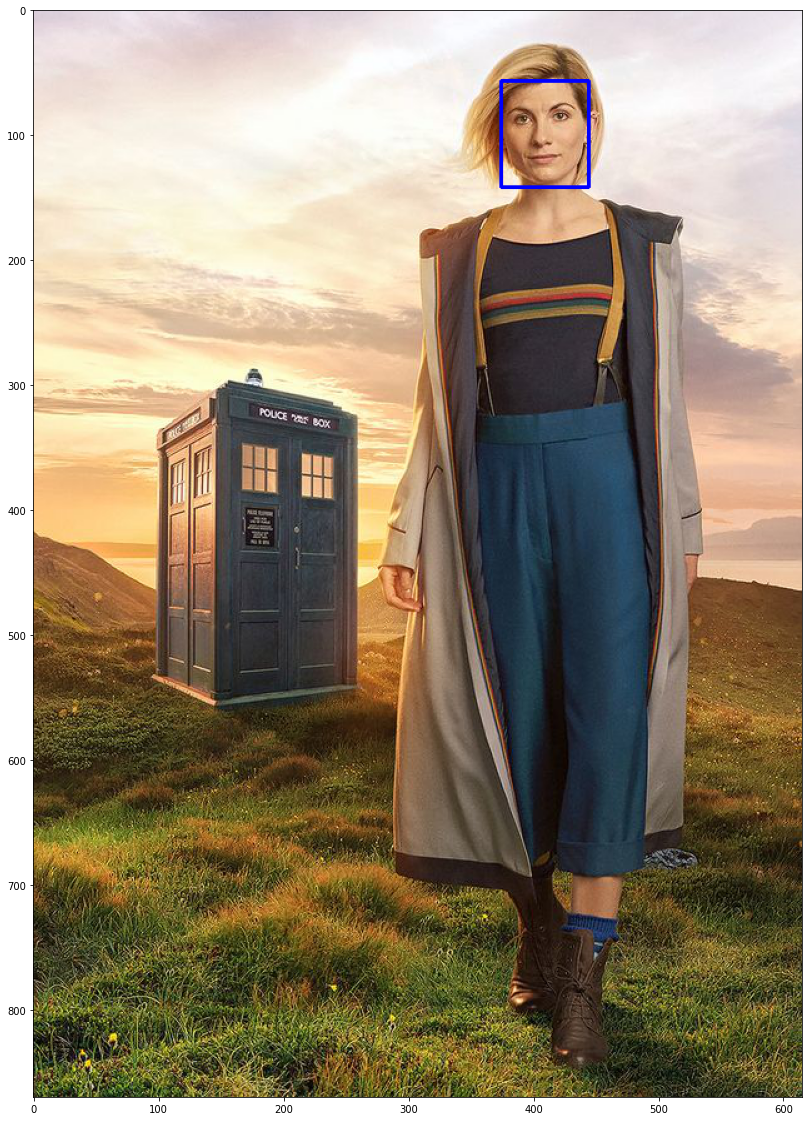

In [ ]:
import matplotlib.pyplot as plt

image =cv2.rectangle(image, start_point, end_point, color, thickness)
# cv2.imshow(window_name, image)


plt.figure(figsize=(20,20))
plt.imshow(image)